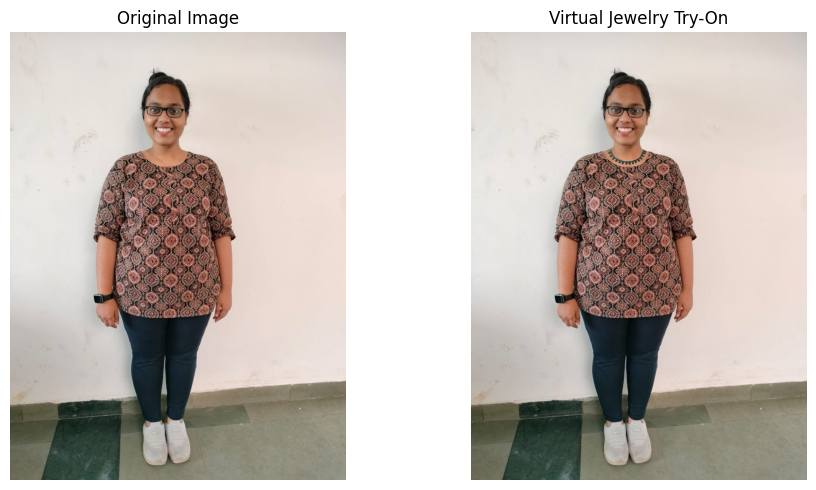

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load face cascade 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load image of the user's face and the jewelry item
face_img = cv2.imread(r"C:\Users\User\Downloads\Project_Kurti\HP\HP & PE dataset\TK_165.jpeg")
jewelry_img = cv2.imread(r"C:\Users\User\Downloads\WhatsApp_Image_2025-04-28_at_5.09.37_PM-removebg-preview.png", cv2.IMREAD_UNCHANGED)  # Load image with alpha channel

# Convert the image to grayscale for face detection
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Create a copy of the original image to work with
result_img = face_img.copy()

for (x, y, w, h) in faces:
    
    # Calculate the position to place the necklace (centered horizontally on the face, slightly below the bottom)
    necklace_x = x + w // 7  # Adjust these values as needed
    necklace_y = y + h + h // 10  # Adjust these values as needed (increase the offset to move the necklace downward)
    
    # Make sure jewelry_img has an alpha channel
    if jewelry_img.shape[2] == 3:  # If it doesn't have an alpha channel
        # Create an alpha channel (all opaque)
        alpha = np.ones((jewelry_img.shape[0], jewelry_img.shape[1], 1), dtype=jewelry_img.dtype) * 255
        jewelry_img = np.concatenate((jewelry_img, alpha), axis=2)
    
    # Split the jewelry into left and right parts
    jewelry_width = jewelry_img.shape[1]
    jewelry_left = jewelry_img[:, :jewelry_width//2]
    jewelry_right = jewelry_img[:, jewelry_width//2:]
    
    # Resize jewelry to fit the face
    jewelry_width_left = int(0.4 * w)  # Adjust this multiplier as needed for the left side
    jewelry_width_right = int(0.4 * w)  # Adjust this multiplier as needed for the right side
    jewelry_height = int(0.4 * h)  # Adjust this multiplier as needed
    
    # Resize left and right parts
    resized_jewelry_left = cv2.resize(jewelry_left, (jewelry_width_left, jewelry_height))
    resized_jewelry_right = cv2.resize(jewelry_right, (jewelry_width_right, jewelry_height))
    
    # Create masks for the jewelry images
    jewelry_mask_left = resized_jewelry_left[:, :, 3] / 255.0
    jewelry_mask_right = resized_jewelry_right[:, :, 3] / 255.0
    
    # Reshape masks for broadcasting
    jewelry_mask_left = jewelry_mask_left[:, :, np.newaxis]
    jewelry_mask_right = jewelry_mask_right[:, :, np.newaxis]
    
    # Invert the masks
    jewelry_mask_inv_left = 1.0 - jewelry_mask_left
    jewelry_mask_inv_right = 1.0 - jewelry_mask_right
    
    # Make sure we don't go out of image bounds
    max_height_left = min(resized_jewelry_left.shape[0], result_img.shape[0] - necklace_y)
    max_width_left = min(resized_jewelry_left.shape[1], result_img.shape[1] - necklace_x)
    
    max_height_right = min(resized_jewelry_right.shape[0], result_img.shape[0] - necklace_y)
    max_width_right = min(resized_jewelry_right.shape[1], result_img.shape[1] - (necklace_x + jewelry_width_left))
    
    # Adjust jewelry and masks if needed
    if max_height_left < resized_jewelry_left.shape[0] or max_width_left < resized_jewelry_left.shape[1]:
        resized_jewelry_left = resized_jewelry_left[:max_height_left, :max_width_left]
        jewelry_mask_left = jewelry_mask_left[:max_height_left, :max_width_left]
        jewelry_mask_inv_left = jewelry_mask_inv_left[:max_height_left, :max_width_left]
    
    if max_height_right < resized_jewelry_right.shape[0] or max_width_right < resized_jewelry_right.shape[1]:
        resized_jewelry_right = resized_jewelry_right[:max_height_right, :max_width_right]
        jewelry_mask_right = jewelry_mask_right[:max_height_right, :max_width_right]
        jewelry_mask_inv_right = jewelry_mask_inv_right[:max_height_right, :max_width_right]
    
    # Calculate overlay regions for left and right sides
    overlay_region_left = result_img[necklace_y:necklace_y+max_height_left, necklace_x:necklace_x+max_width_left]
    
    # Check if right side would go out of bounds
    if necklace_x + jewelry_width_left + max_width_right <= result_img.shape[1]:
        overlay_region_right = result_img[necklace_y:necklace_y+max_height_right, 
                                         necklace_x+jewelry_width_left:necklace_x+jewelry_width_left+max_width_right]
        
        # Blend images using the masks for left side
        overlay_left = (jewelry_mask_left * resized_jewelry_left[:, :, :3] + 
                        jewelry_mask_inv_left * overlay_region_left).astype(np.uint8)
        result_img[necklace_y:necklace_y+max_height_left, necklace_x:necklace_x+max_width_left] = overlay_left
        
        # Blend images using the masks for right side
        overlay_right = (jewelry_mask_right * resized_jewelry_right[:, :, :3] + 
                        jewelry_mask_inv_right * overlay_region_right).astype(np.uint8)
        result_img[necklace_y:necklace_y+max_height_right, 
                  necklace_x+jewelry_width_left:necklace_x+jewelry_width_left+max_width_right] = overlay_right

# Convert BGR to RGB for displaying with matplotlib
original_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

# Display the original and result images side by side
plt.figure(figsize=(10, 5))

# Original image on the left
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title('Original Image')
plt.axis('off')

# Try-on result on the right
plt.subplot(1, 2, 2)
plt.imshow(result_img_rgb)
plt.title('Virtual Jewelry Try-On')
plt.axis('off')

plt.tight_layout()
plt.show()
